In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pricing/pricing.csv


# Business Problem

A Game Company gives gift coins to their users for purchasing items.

The users purchase various tools for their characters by using this coins.

The company does not remark any price for any item and it provides users to buy this item at the price they wanted.

In other words while one user pay 30 units for any item, other user also might pay 45 units for the same item. Therefore, users could buy this item with the amounts that they can afford to pay.



# Project Goal

1. Are there any difference for item's price according to category id's?
2. What price should it be for this item?
3. The company wants to be flexible for the price. Therefore, create a decision support system for price strategies.
4. Simulate item purchases and income for price change possibilities.



# Dataset and Descriptive Statistics

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

In [3]:
df_ = pd.read_csv("/kaggle/input/pricing/pricing.csv", sep=";")
df = df_.copy()

In [4]:
df.head()

,category_id,price
0,489756,32.117753
1,361254,30.711370
2,361254,31.572607
3,489756,34.543840
4,489756,47.205824


> **Defining functions for taking a quick look to dataset**

In [5]:
def check_data(dataframe, head=5):
    """It returns descriptive statistics and information about a given dataset"""
    print ("####### SHAPE #######")
    print (dataframe.shape)
    print ("####### INFO #######")
    print (dataframe.info ())
    print ("####### DESCRIBE #######")
    print (dataframe.describe ([0.01, 0.1, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]))
    print ("####### NA VALUES #######")
    print (dataframe.isnull ().sum ())
    print ("####### FIRST {} ROWS #######".format (head))
    print (dataframe.head (head))
    
def defining_quantile_th(dataframe, col, quantilelow=0, quantileup=1):
    """It returns, when outliers were truncated by using given quantiles what percentage of observations will be affected"""
    up_ratio = (len (dataframe[dataframe[col] > dataframe[col].quantile (quantileup)]) / dataframe[col].shape[0]) * 100
    low_ratio = (len (dataframe[dataframe[col] < dataframe[col].quantile (quantilelow)]) / dataframe[col].shape[
        0]) * 100
    total_ratio = up_ratio + low_ratio
    print (
        "When quantified in the {} - {} range, %{} of customers' data will be truncated.".format (
            quantilelow, quantileup, round (total_ratio, 2)))
    
def outliers_threshold(dataframe, col, low_ratio, up_ratio):
    """It truncates the outliers by using given low and up quantiles and assings to given column of dataset"""
    threshold_range = dataframe[col].quantile (up_ratio) - dataframe[col].quantile (low_ratio)
    up_limit = dataframe[col].quantile (up_ratio) + 1.5 * threshold_range
    low_limit = dataframe[col].quantile (low_ratio) - 1.5 * threshold_range
    dataframe.loc[dataframe[col] > up_limit, "price"] = up_limit
    dataframe.loc[dataframe[col] < low_limit, "price"] = low_limit



In [6]:
check_data (df)

####### SHAPE #######
(3448, 2)
####### INFO #######
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3448 entries, 0 to 3447
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   category_id  3448 non-null   int64  
 1   price        3448 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 54.0 KB
None
####### DESCRIBE #######
         category_id          price
count    3448.000000    3448.000000
mean   542415.171984    3254.475770
std    192805.689911   25235.799009
min    201436.000000      10.000000
1%     201436.000000      30.000000
10%    361254.000000      30.000000
25%    457630.500000      31.890438
50%    489756.000000      34.798544
75%    675201.000000      41.536211
90%    874521.000000      62.505610
95%    874521.000000      92.978218
99%    874521.000000  201436.464204
max    874521.000000  201436.991255
####### NA VALUES #######
category_id    0
price          0
dtype: int64
####### FIRST 5

In [7]:
defining_quantile_th (df, "price", 0.05, 0.95) 

When quantified in the 0.05 - 0.95 range, %5.34 of customers' data will be truncated.


In [8]:
df["price"].value_counts ().sort_values (ascending=False)

30.000000     423
35.000000      79
10.000000       7
33.000000       4
200.000000      2
             ... 
30.797158       1
34.937488       1
32.685002       1
34.450954       1
34.837568       1
Name: price, Length: 2938, dtype: int64

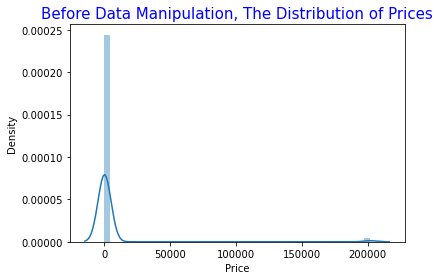

In [9]:
# Taking a quick look to the distribution of prices, before data manipulation by using distplot
sns.distplot (df["price"])
plt.xlabel("Price")
plt.ylabel("Density")
plt.title("Before Data Manipulation, The Distribution of Prices", size=(15), color="blue")
plt.show ();

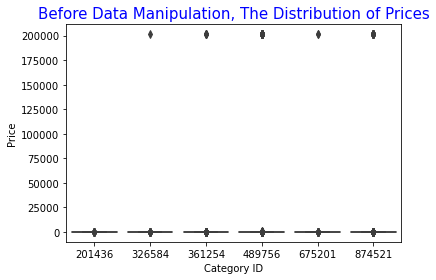

In [10]:
# Taking a quick look to the distribution of prices for each category ids, before data manipulation by using boxplot
sns.boxplot (x="category_id", y="price", data=df)
plt.xlabel("Category ID")
plt.ylabel("Price")
plt.title("Before Data Manipulation, The Distribution of Prices", size=(15), color="blue")
plt.show ();

> **Truncating outliers**

In [11]:
outliers_threshold (df, "price", 0.05, 0.95)

In [12]:
check_data (df)

####### SHAPE #######
(3448, 2)
####### INFO #######
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3448 entries, 0 to 3447
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   category_id  3448 non-null   int64  
 1   price        3448 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 54.0 KB
None
####### DESCRIBE #######
         category_id        price
count    3448.000000  3448.000000
mean   542415.171984    43.682471
std    192805.689911    28.218201
min    201436.000000    10.000000
1%     201436.000000    30.000000
10%    361254.000000    30.000000
25%    457630.500000    31.890438
50%    489756.000000    34.798544
75%    675201.000000    41.536211
90%    874521.000000    62.505610
95%    874521.000000    92.978218
99%    874521.000000   187.445544
max    874521.000000   187.445544
####### NA VALUES #######
category_id    0
price          0
dtype: int64
####### FIRST 5 ROWS #######
   category_id

In [13]:
# The distribution of prices after data manipulation
df["price"].value_counts ().sort_values (ascending=False)

30.000000     423
35.000000      79
187.445544     77
10.000000       7
33.000000       4
             ... 
34.937488       1
32.685002       1
34.450954       1
34.619289       1
34.837568       1
Name: price, Length: 2863, dtype: int64

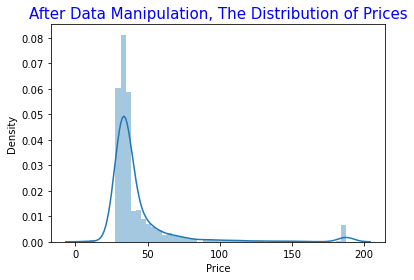

In [14]:
# Taking a quick look to the distribution of prices, after data manipulation by using distplot
sns.distplot (df["price"])
plt.xlabel("Price")
plt.ylabel("Density")
plt.title("After Data Manipulation, The Distribution of Prices", size=(15), color="blue")
plt.show ();

In [15]:
# Taking a look to some of descriptive statistics for each category ids
df.groupby ("category_id").agg ({"price": ["count", "median", "mean", "std", "min", "max"]})

price                                                   
            count     median       mean        std   min         max
category_id                                                         
201436         97  33.534678  36.175498   8.900154  30.0   74.452929
326584        145  31.748242  36.739739  17.400222  30.0  187.445544
361254        620  34.459195  36.702812  16.152671  30.0  187.445544
489756       1705  35.635784  47.569117  31.258245  10.0  187.445544
675201        131  33.835566  39.733698  21.512874  30.0  187.445544
874521        750  34.400860  43.619565  31.356950  10.0  187.445544

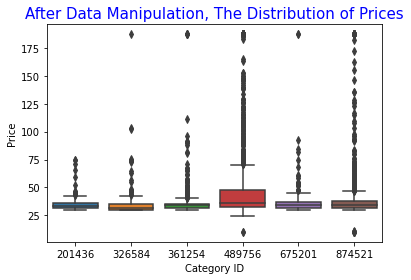

In [16]:
# Taking a quick look to the distribution of prices for each category ids, after data manipulation by using boxplot
sns.boxplot (x="category_id", y="price", data=df)
plt.xlabel("Category ID")
plt.ylabel("Price")
plt.title("After Data Manipulation, The Distribution of Prices", size=(15), color="blue")
plt.show ();

# A/B Testing

Defining functions for checking the normality and do ab testing

In [17]:
def normality_test(dataframe, col, class_col):
    """It returns a dataframe which has normality test results of given column and classes of column. 
    It also returns two lists while one has classes of column as non-normal distribution 
    and the other has normal distribution."""
    # H0 : normal distribution
    # H1 : nonnormal distribution
    from scipy.stats import shapiro
    category_ids = list (set (dataframe[class_col]))
    df = pd.DataFrame()
    nonnormal = []
    normal = []
    for i in category_ids:
        ttest, p_value = shapiro (dataframe.loc[dataframe[class_col] == i, col])
        if p_value < 0.05:
            df = df.append({"Category_ID":str(i),"Distribution": "Non-normal Distribution", "Hypothesis_Situation":"H0 was Rejected"}, ignore_index=True)
            nonnormal.append(i)
        else:
            df = df.append ({"Category_ID": str (i), "Distribution": "Normal Distribution", "Hypothesis_Situation":"H0 was Failed to Reject"}, ignore_index=True)
            normal.append(i)
    return nonnormal, normal, df

In [18]:
nonnormal_list, normal_list, normality_df = normality_test (df, "price","category_id")

In [19]:
normality_df

,Category_ID,Distribution,Hypothesis_Situation
0,675201,Non-normal Distribution,H0 was Rejected
1,201436,Non-normal Distribution,H0 was Rejected
2,361254,Non-normal Distribution,H0 was Rejected
3,326584,Non-normal Distribution,H0 was Rejected
4,874521,Non-normal Distribution,H0 was Rejected
5,489756,Non-normal Distribution,H0 was Rejected


> **"Normal Distribution" hypothesis is declined for all category ids. It means that all categories are distributed non-normally.Therefore we could skip the Homogeneity of Variance Test. Let's pass to A/B Testing**

In [20]:
def nonparametric_ind_ab_test(dataframe, col, class_col, nonnormally_list):
    """It returns two lists end of the nonparametric independent ab testing 
    while one has the classes of similar averages 
    and the other has the classes of different averages."""
    # H0: There is no difference between the average  of two groups
    # H1: There is difference between the average of two groups
    from scipy.stats import mannwhitneyu
    different_avg = []
    similar_avg = []
    for i in range (len (nonnormally_list)):
        for k in range (i + 1, len (nonnormally_list)):
            ttest_lev, p_value_lev = mannwhitneyu ((dataframe.loc[df[class_col] == nonnormally_list[i], col]),
                                                   (dataframe.loc[dataframe[class_col] == nonnormally_list[k], col]))
            if p_value_lev < 0.05:
                different_avg.append ((nonnormally_list[i], nonnormally_list[k]))
            else:
                similar_avg.append ((nonnormally_list[i], nonnormally_list[k]))
    return similar_avg, different_avg

> **Let's take a look at the categories which their averages are similar and different.**

In [21]:
sim_avg, diff_avg = nonparametric_ind_ab_test (df, "price", "category_id", nonnormal_list)

In [22]:
sim_avg

[(675201, 201436),
 (675201, 361254),
 (675201, 874521),
 (201436, 361254),
 (201436, 874521)]

In [23]:
diff_avg

[(675201, 326584),
 (675201, 489756),
 (201436, 326584),
 (201436, 489756),
 (361254, 326584),
 (361254, 874521),
 (361254, 489756),
 (326584, 874521),
 (326584, 489756),
 (874521, 489756)]

In [24]:
# Converting a dataframe of non-parametric ab testing results.
sim_df = pd.DataFrame ({"Category_IDs": sim_avg})
sim_df["AB_Test_Result"] = "No difference"

diff_df = pd.DataFrame ({"Category_IDs": diff_avg})
diff_df["AB_Test_Result"] = "There is a difference"

ab_test_df = pd.concat ([sim_df, diff_df], axis=0).reset_index (drop=True)
ab_test_df 

,Category_IDs,AB_Test_Result
0,"(675201, 201436)",No difference
1,"(675201, 361254)",No difference
2,"(675201, 874521)",No difference
3,"(201436, 361254)",No difference
4,"(201436, 874521)",No difference
5,"(675201, 326584)",There is a difference
6,"(675201, 489756)",There is a difference
7,"(201436, 326584)",There is a difference
8,"(201436, 489756)",There is a difference
9,"(361254, 326584)",There is a difference


In [25]:
def comparing(dataframe, col, class_col, list_):
    """It compares the classes of column in a given list by using some of descriptive statistics"""
    for i in list_:
        new_df = pd.concat ([dataframe[dataframe[class_col] == i[0]], dataframe[dataframe[class_col] == i[1]]],
                            axis=0).reset_index (drop=True)
        print (new_df.groupby (class_col).agg ({col: ["mean", "median", "std"]}))

> **Comparing descriptive statistics of categories which have different averages**

In [26]:
comparing (df, "price", "category_id", diff_avg) 

                 price                      
                  mean     median        std
category_id                                 
326584       36.739739  31.748242  17.400222
675201       39.733698  33.835566  21.512874
                 price                      
                  mean     median        std
category_id                                 
489756       47.569117  35.635784  31.258245
675201       39.733698  33.835566  21.512874
                 price                      
                  mean     median        std
category_id                                 
201436       36.175498  33.534678   8.900154
326584       36.739739  31.748242  17.400222
                 price                      
                  mean     median        std
category_id                                 
201436       36.175498  33.534678   8.900154
489756       47.569117  35.635784  31.258245
                 price                      
                  mean     median        std
category_i

> **I would like to accept categories which have similar averages as a single category**

In [27]:
similar_categories = set ()
for i in sim_avg:
    similar_categories.add (i[0])
    similar_categories.add (i[1])

different_categories = set (df["category_id"].unique()) - similar_categories

different_categories

{326584, 489756}

In [28]:
similar_categories

{201436, 361254, 675201, 874521}

In [29]:
def price_df(dataframe, low_price, high_price, median_price, method_name):
    """It returns a dataframe which calculates incomes and count that affected with given low, high and median prices."""
    mean_price = (low_price + high_price) / 2
    income_p_mean = dataframe.loc[dataframe["price"] >= mean_price].shape[0] * mean_price
    income_p_median = dataframe.loc[dataframe["price"] >= median_price].shape[0] * median_price
    income_p_lower = dataframe.loc[dataframe["price"] >= low_price].shape[0] * low_price
    income_p_upper = dataframe.loc[dataframe["price"] >= high_price].shape[0] * high_price
    df = pd.DataFrame ({"Income_according_to_mean": income_p_mean,
                        "Mean_price": [mean_price],
                        "Mean_count": [dataframe.loc[dataframe["price"] >= mean_price].shape[0]],
                        "Income_according_to_median": income_p_median,
                        "Median_price":[median_price],
                        "Median_count":[dataframe.loc[dataframe["price"] >= median_price].shape[0]],
                        "Income_according_to_low_price": income_p_lower,
                        "Lower_price": [low_price],
                        "Low_price_count": [dataframe.loc[dataframe["price"] >= low_price].shape[0]],
                        "Income_according_to_high_price": income_p_upper,
                        "High_price": [high_price],
                        "High_price_count": [dataframe.loc[dataframe["price"] >= high_price].shape[0]]})
    df.insert (loc=0, column="Method", value=[method_name])
    return df

# Confidence Intervals

In [30]:
# Determining lower and upper limits of confidence intervals and average of lower and upper limits and mean values 
# according to determined categories

from statsmodels.stats.api import DescrStatsW

lower, upper = DescrStatsW (df["price"]).tconfint_mean ()
median_all = df["price"].median()

all_df = price_df (df, lower, upper, median_all, "According_to_all_cat_ids")

In [31]:
low_lim, high_lim = DescrStatsW (df.loc[df["category_id"] != 326584, "price"]).tconfint_mean ()
median_exc32 = df.loc[df["category_id"] != 326584, "price"].median()

exc_cat3_df = price_df (df, low_lim, high_lim, median_exc32, "Excepted_326584_id_prices")

In [32]:
low_limit, high_limit = DescrStatsW (df.loc[df["category_id"] != 489756, "price"]).tconfint_mean ()
median_exc48 = df.loc[df["category_id"] != 489756, "price"].median()

exc_cat4_df = price_df (df, low_limit, high_limit, median_exc48, "Excepted_489756_id_prices")

In [33]:
lower_lim, higher_lim = DescrStatsW (df.loc[(df["category_id"] != 489756) & (df["category_id"] != 326584), "price"]).tconfint_mean ()
median_similar = df.loc[(df["category_id"] != 489756) & (df["category_id"] != 326584), "price"].median()

similar_prices_df = price_df (df, lower_lim, higher_lim, median_similar, "Similar_cat_id_prices")

In [34]:
final_df = pd.concat([all_df, exc_cat3_df, exc_cat4_df, similar_prices_df]).reset_index(drop=True)

In [35]:
final_df

,Method,Income_according_to_mean,Mean_price,Mean_count,Income_according_to_median,Median_price,Median_count,Income_according_to_low_price,Lower_price,Low_price_count,Income_according_to_high_price,High_price,High_price_count
0,According_to_all_cat_ids,33023.948406,43.682471,756,59992.690447,34.798544,1724,34192.211589,42.740264,800,31951.269726,44.624678,716
1,Excepted_326584_id_prices,32374.618826,43.987254,736,59192.818424,34.860317,1698,33679.041907,43.012825,783,31518.139618,44.961683,701
2,Excepted_489756_id_prices,37687.129635,39.880560,945,67754.149725,34.219268,1980,37537.957453,38.738862,969,36304.698986,41.022259,885
3,Similar_cat_id_prices,37434.296041,40.165554,932,66286.964222,34.399047,1927,36883.554588,38.947787,947,35962.105139,41.383320,869


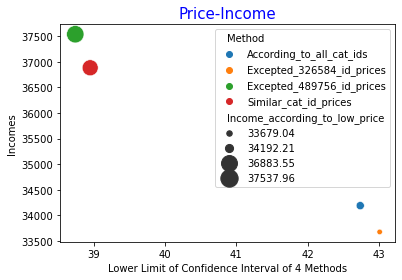

In [36]:
sns.scatterplot(x="Lower_price", y="Income_according_to_low_price", hue="Method", data=final_df, 
                size = round(final_df["Income_according_to_low_price"], 2), sizes=(30,300))
plt.xlabel("Lower Limit of Confidence Interval of 4 Methods")
plt.ylabel("Incomes")
plt.title("Price-Income", size=(15), color="blue")
plt.show();

In [37]:
median_df = (final_df[["Method","Income_according_to_median", "Median_price", "Median_count"]]
 .sort_values(by="Income_according_to_median",ascending=False)).reset_index(drop=True)

median_df

,Method,Income_according_to_median,Median_price,Median_count
0,Excepted_489756_id_prices,67754.149725,34.219268,1980
1,Similar_cat_id_prices,66286.964222,34.399047,1927
2,According_to_all_cat_ids,59992.690447,34.798544,1724
3,Excepted_326584_id_prices,59192.818424,34.860317,1698


In [38]:
temp_df = final_df.drop(["Income_according_to_median", "Median_price", "Median_count"], axis=1)

In [39]:
# Arranging a new dataframe according to confidence interval limits and averages

low_confint_df = temp_df.iloc[:,4:7]
high_confint_df = temp_df.iloc[:, 7:]
avg_confint_df = temp_df.iloc[:, 1:4]

low_confint_df["Approach"] = "Lower Limit of Confidence Interval"
high_confint_df["Approach"] = "Upper Limit of Confidence Interval"
avg_confint_df["Approach"] = "Average Value of Confidence Interval"

low_confint_df.rename(columns={"Income_according_to_low_price":"Income",
                              "Lower_price":"Price",
                              "Low_price_count":"Count"}, inplace=True)
high_confint_df.rename(columns={"Income_according_to_high_price":"Income",
                              "High_price":"Price",
                              "High_price_count":"Count"}, inplace=True)
avg_confint_df.rename(columns={"Income_according_to_mean":"Income",
                              "Mean_price":"Price",
                              "Mean_count":"Count"}, inplace=True)

In [40]:
conf_list = [high_confint_df, avg_confint_df, low_confint_df]
for i in conf_list:
    i.insert(0, "Method", final_df[["Method"]])

In [41]:
conf_df = pd.concat(conf_list, axis=0).reset_index(drop=True)

In [42]:
conf_df.insert(4, "User_Ratio" ,round(conf_df["Count"]/len(df), 4))
conf_df["Price"] = round(conf_df["Price"], 2)
conf_df["Income"] = round(conf_df["Income"], 2)

In [43]:
conf_df = conf_df.sort_values(by="Income", ascending=False)
conf_df

,Method,Income,Price,Count,User_Ratio,Approach
6,Excepted_489756_id_prices,37687.13,39.88,945,0.2741,Average Value of Confidence Interval
10,Excepted_489756_id_prices,37537.96,38.74,969,0.2810,Lower Limit of Confidence Interval
7,Similar_cat_id_prices,37434.30,40.17,932,0.2703,Average Value of Confidence Interval
11,Similar_cat_id_prices,36883.55,38.95,947,0.2747,Lower Limit of Confidence Interval
2,Excepted_489756_id_prices,36304.70,41.02,885,0.2567,Upper Limit of Confidence Interval
3,Similar_cat_id_prices,35962.11,41.38,869,0.2520,Upper Limit of Confidence Interval
8,According_to_all_cat_ids,34192.21,42.74,800,0.2320,Lower Limit of Confidence Interval
9,Excepted_326584_id_prices,33679.04,43.01,783,0.2271,Lower Limit of Confidence Interval
4,According_to_all_cat_ids,33023.95,43.68,756,0.2193,Average Value of Confidence Interval
5,Excepted_326584_id_prices,32374.62,43.99,736,0.2135,Average Value of Confidence Interval


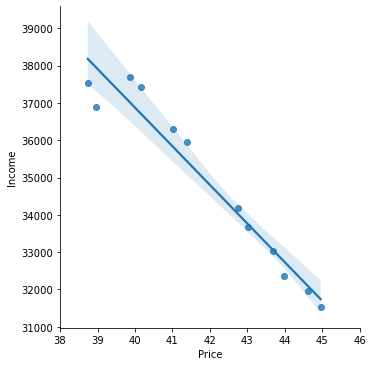

In [44]:
sns.lmplot(x="Price", y="Income", data=conf_df)
plt.xlim((38, 46))
plt.show();

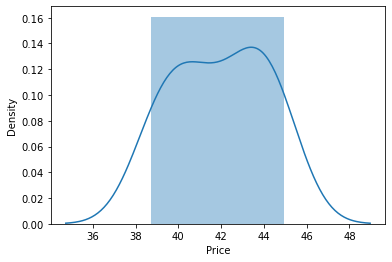

In [45]:
sns.distplot(conf_df["Price"])
plt.show();



# Conclusion

Prices are not normally distributed according to category ids. That is why non-parametric A/B Testing was performed. As a result of A/B Testing, it was observed that there was no statistically significant difference between the price averages of 201436, 361254, 675201, 874521 category ids and these category ids were accepted as a single category in some calculations. It was observed that the averages of 326584, 489756 category ids were statistically different from the others. These two category ids were evaluated as two seperate groups.

Because the data were not normally distributed, the median values of each category were examined. In order to provide price flexibility, calculations were made according to the lower and upper limits of the 95% confidence interval and the average values of the lower and upper limits.

What should be the price of the item? The price is determined by four different methods.
* To determine the median value of all prices in whole dataset as price without distinction between categories.
* To determine the median value of the prices of similar categories as price.
* To determine the median value of the prices outside the category id 326584 as price.
* To determine the median value of the prices outside the category id 489756 as price.

When the median value of the prices other than the 489756 category id is considered as the item price; the item price was 34.21 units, and the total income reached its highest value with 67754.14 units.

What should be the price flexibility? The income distribution was examined by determining the lower and upper limit of confidence interval values and the average of the lower and upper limit values of each 4 different methods as price. When the confidence interval of prices outside the category id of 489756 is 39.88 units, which is the average of the lower and upper limit, it has been observed that the income is 37687.13 units and reaches the highest value.

It has been observed that the price range is between 38.74 and 44.96 units, and a graph of the income obtained according to the relevant prices has been created. As analyzed on the graph it is seen when the unit price increases, the income decreases.
 
In the analyzed dataset; a single price was applied to all categories because there are no concepts such as cost, category features, flexibility of transition between categories. However, incase of having detailed information about the relevant situations, the pricing specific to each category can be examined in detail.

